In [1]:
from bayes_opt import BayesianOptimization
from L1_DifferentialEvolution import extract_data, model, diff_evolution
from scipy.optimize import Bounds
from scipy.optimize import minimize
from NelderMead import bounded_nelder_mead
from losses import Losses
import math
import physics
import numpy as np
import matplotlib.pyplot as plt

In [2]:
frequency, intensity = extract_data() # extracting the desired information

# compressor parameters - obtained as minus the stretcher one - TO BE FIXED WITH REAL ONES ONCE THEY ARE AVAILABLE
COMPRESSOR = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
# non linearity parameter
B = 2
# cutoff frequencies, in THz, used to remove noise - derived from visual inspection
CUTOFF = (289.95, 291.91)
# model instantiation
l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF, num_points=int(5e3))

losses = Losses(l1_pump)

bounds_DE = Bounds(
            # GDD         # TOD          # FOD
    lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
    ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
)

bounds_matrix = np.vstack((bounds_DE.lb, bounds_DE.ub)).T
disp_bounds = np.sort(l1_pump.translate_control(bounds_matrix, verse = "to_disp"))

In [3]:
def outer_objfunc(mutation:float, cross_p:float, population_size:float) -> float: 
    """
    This is the outher objective function which is taking as input values characteristic of the 
    optimisation process.
    For further documentantion on the relevance of these parameters and their effect on the optimisation 
    route check literature.
    """
    population_size = int(population_size) # must be int
    
    candidate_best = diff_evolution(
        objective_function = losses.loss3,
        bounds = disp_bounds,
        mutation = mutation, 
        cross_p = cross_p, 
        population_size = population_size,
        verbose = 0, 
        maxit = 20, 
        print_every = 50,
        print_NM_progress = 0
    )
    
    return -1 * losses.loss3(candidate_best) # maximizing

In [4]:
params_bounds = {
    "mutation": (0.5, 1.99), 
    "cross_p": (0, 1), 
    "population_size": (10, 50)
}

optimizer = BayesianOptimization(
    f = outer_objfunc, 
    pbounds = params_bounds, 
    random_state = 10, 
    verbose = 1
)

n_init, n_iter = 20, 20
optimizer.maximize(init_points = n_init, n_iter = n_iter)

|   iter    |  target   |  cross_p  | mutation  | popula... |
-------------------------------------------------------------
DE function evaluations = 700
Total function evaluations = 1828
DE function evaluations = 360
Total function evaluations = 1735
DE function evaluations = 320
Total function evaluations = 1239
DE function evaluations = 960
Total function evaluations = 2160
|  4        | -1.443    |  0.08834  |  1.521    |  48.14    |
DE function evaluations = 840
Total function evaluations = 1804
|  5        | -1.443    |  0.003948 |  1.263    |  42.5     |
DE function evaluations = 420
Total function evaluations = 1651
|  6        | -1.443    |  0.6125   |  1.575    |  21.68    |
DE function evaluations = 620
Total function evaluations = 1955
DE function evaluations = 720
Total function evaluations = 1619
DE function evaluations = 680
Total function evaluations = 1829
DE function evaluations = 680
Total function evaluations = 1849
|  10       | -1.443    |  0.5131   |  1.469    | 

In [12]:
cross_p, mutation, pop_size = optimizer.max["params"].values()
# training with the best parameters and increased number of iterations
candidate_best = diff_evolution(
        objective_function = losses.loss3,
        bounds = disp_bounds,
        mutation = mutation, 
        cross_p = cross_p, 
        population_size = int(pop_size),
        verbose = 1, 
        maxit = 10, 
        print_every = 1,
        print_NM_progress = 1
)
print(losses.loss3(candidate_best))
print(candidate_best)

Iteration 0 - Objective Function value: 17.670256851338287
Iteration 1 - Objective Function value: 17.670256851338287
Iteration 2 - Objective Function value: 17.670256851338287
Iteration 3 - Objective Function value: 17.670256851338287
iteration: 1
best value of objective function so far: 17.534519068768596
best candidate: [-4.74720284e-01 -2.56694398e+07  1.56859005e+15]
iteration: 2
best value of objective function so far: 17.534519068768596
best candidate: [-4.74720284e-01 -2.56694398e+07  1.56859005e+15]
iteration: 3
best value of objective function so far: 17.534519068768596
best candidate: [-4.74720284e-01 -2.56694398e+07  1.56859005e+15]
iteration: 4
best value of objective function so far: 17.534519068768596
best candidate: [-4.74720284e-01 -2.56694398e+07  1.56859005e+15]
iteration: 5
best value of objective function so far: 17.534519068768596
best candidate: [-4.74720284e-01 -2.56694398e+07  1.56859005e+15]
iteration: 6
best value of objective function so far: 17.534519068768

iteration: 68
best value of objective function so far: 2.136755884714365
best candidate: [-4.75072966e-01 -7.31960752e+06 -3.59081783e+14]
iteration: 69
best value of objective function so far: 2.1357971365098485
best candidate: [-4.75034335e-01 -7.27644392e+06 -3.73695807e+14]
iteration: 70
best value of objective function so far: 2.1357431503279716
best candidate: [-4.75063170e-01 -7.29321389e+06 -3.64037579e+14]
iteration: 71
best value of objective function so far: 2.1357431503279716
best candidate: [-4.75063170e-01 -7.29321389e+06 -3.64037579e+14]
iteration: 72
best value of objective function so far: 2.1348679124690366
best candidate: [-4.75059072e-01 -7.30286074e+06 -3.64225655e+14]
iteration: 73
best value of objective function so far: 2.1348679124690366
best candidate: [-4.75059072e-01 -7.30286074e+06 -3.64225655e+14]
iteration: 74
best value of objective function so far: 2.1346922231572605
best candidate: [-4.75051472e-01 -7.29592033e+06 -3.66353103e+14]
iteration: 75
best va

iteration: 55
best value of objective function so far: 1.443591309932963
best candidate: [-4.75472494e-01 -6.94255897e+06  1.56825076e+15]
iteration: 56
best value of objective function so far: 1.4435150313248317
best candidate: [-4.75472343e-01 -6.94408371e+06  1.56819421e+15]
iteration: 57
best value of objective function so far: 1.4434252568280252
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56812824e+15]
iteration: 58
best value of objective function so far: 1.4434252568280252
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56812824e+15]
function evaluations: 108
1.4434252568280252
Iteration 6 - Objective Function value: 1.4434252568280252
Iteration 7 - Objective Function value: 1.4434252568280252
iteration: 1
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]
iteration: 2
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]


iteration: 20
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]
iteration: 21
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]
iteration: 22
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]
iteration: 23
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]
iteration: 24
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]
iteration: 25
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]
iteration: 26
best value of objective function so far: 1.4433596037023186
best candidate: [-4.75473168e-01 -6.95254019e+06  1.56859005e+15]
iteration: 27
best v

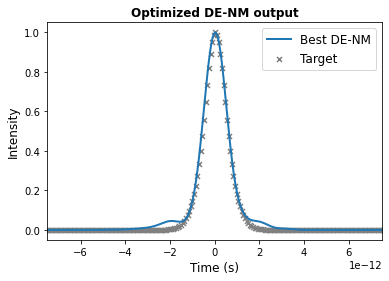

In [6]:
time, profile = l1_pump.forward_pass(candidate_best)
fig, ax = plt.subplots()

ax.set_title("Optimized DE-NM output", fontweight = "bold")
ax.scatter(losses.target_time, losses.target_profile, marker = "x", c = "grey", s = 25, label = "Target")
ax.plot(losses.target_time, np.roll(profile, - np.argmax(profile) + np.argmax(losses.target_profile)), label = "Best DE-NM", lw = 2)

ax.set_xlim(-7.5e-12, 7.5e-12); ax.set_xlabel("Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)
ax.legend(fontsize = 12)
plt.show()